In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# FENICSx imports
import ufl
import dolfinx
from mpi4py import MPI
from petsc4py.PETSc import ScalarType as dtype

sys.path.append('..')
%aimport mre_pinn

dtype

numpy.complex128

<IPython.core.display.Javascript object>


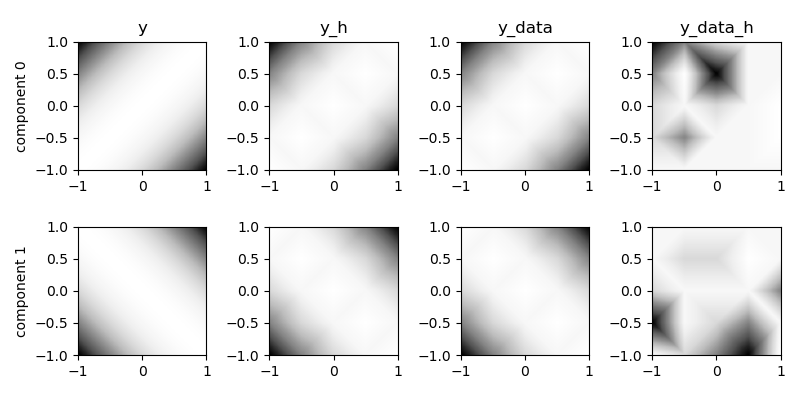

In [61]:
from scipy.interpolate import LinearNDInterpolator

# define a vector-valued function f: R^2 \to R^2
#   NOTE that in reality, I do not have an explicit function like this
f = lambda x: np.stack([
    (x[0] + x[1])**2,
    (x[0] - x[1])**2
], axis=0)

def sample_domain(n):
    x = np.linspace(-1, 1, n)
    return np.stack(np.meshgrid(x, x), axis=-1).reshape(-1, 2)

# evaluate f on a set of domain samples
n = 100
x = sample_domain(n)
y = f(x.T).T

# create an FEM mesh and basis
n_nodes = 5 # per dimension
mesh = dolfinx.mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[[-1, -1], [1, 1]],
    n=[n_nodes - 1, n_nodes - 1],
    cell_type=dolfinx.mesh.CellType.triangle,
    diagonal=dolfinx.mesh.DiagonalType.right_left
)
V = dolfinx.fem.VectorFunctionSpace(mesh, ('Lagrange', 1), dim=2)

# interpolate f into the FEM basis
f_h = dolfinx.fem.Function(V)
f_h.interpolate(f)

def eval_func(f_h, x):
    '''Evaluate a dolfinx function on a set of 2D points.'''
    x = np.concatenate([x, np.zeros((len(x), 1))], axis=1)
    tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
    cells = dolfinx.geometry.compute_collisions(tree, x)
    cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
    cells = [cells.links(i)[0] for i in range(x.shape[0])]
    return f_h.eval(x, cells)

# evaluate the FEM function on the domain
y_h = eval_func(f_h, x)

# create data set of samples from f
#   NOTE this is what I have in reality that I want to represent in the FEM basis
n_data = 5
x_data = sample_domain(n_data)
y_data = f(x_data.T).T

# create function that interpolates data samples
f_data = LinearNDInterpolator(x_data, y_data)
y_data = f_data(x)

# interpolate f_data into the FEM basis
f_data_h = dolfinx.fem.Function(V)
f_data_h.interpolate(lambda x: f_data(x[:2].T).T)
y_data_h = eval_func(f_data_h, x)

# reshape into images for plotting
y = y.reshape(n, n, 2)
y_h = y_h.reshape(n, n, 2)
y_data = y_data.reshape(n, n, 2)
y_data_h = y_data_h.reshape(n, n, 2)

# plot the components of y, y_h, y_data, and y_data_h
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

axes[0,0].imshow(y[...,0].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])
axes[1,0].imshow(y[...,1].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])
axes[0,1].imshow(y_h[...,0].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])
axes[1,1].imshow(y_h[...,1].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])
axes[0,2].imshow(y_data[...,0].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])
axes[1,2].imshow(y_data[...,1].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])
axes[0,3].imshow(y_data_h[...,0].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])
axes[1,3].imshow(y_data_h[...,1].real, cmap='Greys', vmin=0, vmax=4, extent=[-1, 1, -1, 1])

axes[0,0].set_ylabel('component 0')
axes[1,0].set_ylabel('component 1')
axes[0,0].set_title('y')
axes[0,1].set_title('y_h')
axes[0,2].set_title('y_data')
axes[0,3].set_title('y_data_h')

fig.tight_layout()

In [49]:
f_data(np.eye(2))

array([[1.00010203, 1.00010203],
       [1.00010203, 1.00010203]])

## 2D Helmholtz inverse FEM

We want to solve for the elasticity field $\mu: \Omega \to \mathbb{C}$ given the wave field $u: \Omega \to \mathbb{C}^2$, where $\Omega \subset \mathbb{R}^2$.

Strong form:

$$
\begin{align}
    \mu(\mathbf{x}) \nabla^2 u(\mathbf{x}) + \rho \omega^2 u(\mathbf{x}) &= 0
\end{align}
$$

In [ ]:
%autoreload

# load the data set
data, _ = mre_pinn.data.load_bioqic_dataset(
    '../data/BIOQIC', 'fem_box', frequency=80, xyz_slice='2D', downsample=False
)
data

In [ ]:
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
mre_pinn.visual.XArrayViewer(data.u, col='part', ax_width=2, **wave_kws)
#mre_pinn.visual.XArrayViewer(data.Lu, col='part', ax_width=2, **laplace_kws)

In [ ]:
x = mesh.geometry.x
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]
cells

In [ ]:
mesh.topology.index_map

In [ ]:
n_frequency, n_x, n_y, n_component = data.u.shape

x = data.u.field.spatial_points()
u = data.u.field.values()
print(x.shape, u.shape)

x_min = x.min(axis=0)
x_max = x.max(axis=0)
print(x_min)
print(x_max)

interp = scipy.interpolate.LinearNDInterpolator(points=x, values=u)
interp_values = interp(x).reshape(data.u.shape)

mesh = dolfinx.mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[x_min, x_max],
    n=[n_x, n_y],
    cell_type=dolfinx.mesh.CellType.triangle
)
V = dolfinx.fem.VectorFunctionSpace(mesh, ('Lagrange', 1), dim=2)
func_pred = dolfinx.fem.Function(V)
func_pred.interpolate(lambda x: interp(x[:2].T).T)

x = data.u.field.spatial_points()
x = np.concatenate([x, np.zeros((len(x), 1))], axis=1)

# identify cells that contain the coordinates
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]

func_values = func_pred.eval(x, cells)
print(func_values.shape)
func_values = func_values.reshape(data.u.shape)

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
axes[0].imshow(u.reshape(data.u.shape)[0,:,:,0].T.real, origin='lower', **wave_kws)
axes[1].imshow(interp_values[0,:,:,0].T.real, origin='lower', **wave_kws)
axes[2].imshow(func_values[0,:,:,0].T.real, origin='lower', **wave_kws)

In [ ]:
# get the domain from the wave field data

n_frequency, n_x, n_y, n_component = data.u.shape
assert n_frequency == 1
#assert n_z == 1

x = data.u.field.spatial_points()
print(x.shape)

x_min = x.min(axis=0)[:2]
x_max = x.max(axis=0)[:2]
print(x_min)
print(x_max)

# define the mesh and function spaces

mesh = dolfinx.mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[x_min, x_max],
    n=[n_x - 1, n_y - 1],
    cell_type=dolfinx.mesh.CellType.triangle
)

scalar_func_space = dolfinx.fem.FunctionSpace(mesh, ('Lagrange', 1))
vector_func_space = dolfinx.fem.VectorFunctionSpace(mesh, ('Lagrange', 1), dim=2)

In [ ]:
data.u.shape

In [ ]:
# visualize the interpolated wave field
data['u_pred'] = mre_pinn.utils.as_xarray(u_pred.reshape(*data.u.shape), like=data.u)
wave_kws = mre_pinn.visual.get_color_kws(data.u_pred)
mre_pinn.visual.XArrayViewer(data.u_pred, col='part', ax_width=2, **wave_kws)

In [ ]:
# identify boundary nodes

def on_boundary(x):
    x = x[:2] # assume only 2D
    x_loc = x.mean(axis=1, keepdims=True)
    x_scale = (x.max(axis=1, keepdims=True) - x.min(axis=1, keepdims=True)) / 2
    x = (x - x_loc) / x_scale
    return np.isclose(np.linalg.norm(x, np.inf, axis=0), 1)

y = on_boundary(x.T)
c = y.astype(float) / 2 + 0.25

fig, ax = plt.subplots(figsize=(4, 5))
ax.scatter(*x.T[:2], c=c, s=2, cmap='Greys', vmin=0, vmax=1)

In [ ]:
# setup physical problem and boundary conditions

rho = 1000
omega = 2 * np.pi * 80

mu_func = dolfinx.fem.Function(scalar_func_space)
mu_func.interpolate(lambda x: 3e3 * np.ones_like(x[0]))

boundary_dofs = dolfinx.fem.locate_dofs_geometrical(vector_func_space, on_boundary)
mu_bc = dolfinx.fem.dirichletbc(mu_func, dofs=boundary_dofs)

Variational form:

$$
\begin{align}
    \int_\Omega \mu \nabla u \cdot \nabla \bar{v} d\Omega &= \int_\Omega \rho \omega^2 u \bar{v} d\Omega
\end{align}
$$

In [ ]:
%%time

# solve variational Helmholtz problem
mu_trial_func = ufl.TrialFunction(scalar_func_space)
v_test_func = ufl.TestFunction(vector_func_space)

f_func = dolfinx.fem.Function(scalar_func_space) # source is zero
f_func.interpolate(lambda x: 0 * x[:1])

Ax = mu_trial_func * ufl.inner(ufl.grad(u_func), ufl.grad(v_test_func)) * ufl.dx
b = rho * omega**2 * ufl.inner(u_func, v_test_func) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(
    Ax, b, bcs=[mu_bc], petsc_options={"ksp_type": "lsqr", "pc_type": "none"}
)
mu_pred_func = problem.solve()

In [ ]:
# evaluate function on mesh

x = data.u.field.points()[:,1:]
x = np.concatenate([x, np.zeros((len(x), 1))], axis=1) # needs to have z dimension

# identify cells that contain the coordinates
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]

mu_pred = mu_pred_func.eval(x, cells)
mu_pred = mu_pred.reshape(*data.mu.shape)
mu_pred.shape, mu_pred.dtype

In [ ]:
# visualize the elastogram

data['mu_pred'] = mre_pinn.utils.as_xarray(mu_pred, like=data.mu)

elast_kws = mre_pinn.visual.get_color_kws(data.mu_pred)

mre_pinn.visual.XArrayViewer(data.mu_pred, ax_width=2, **elast_kws)